# Dimensionality reduction

<hr>

Unsupervised machine learning methods like Principal Component Analysis (PCA) and other dimensionality reduction techniques are invaluable for preparing and exploring datasets before applying supervised models. These techniques help reveal the intrinsic structure of the data by identifying key features or patterns without the need for labeled outputs. By reducing dimensionality, they not only mitigate the risk of overfitting but also make the data more manageable and interpretable, allowing for a clearer understanding of which features are most relevant. This step is crucial for improving the performance and efficiency of supervised learning algorithms by ensuring that only the most informative aspects of the data are considered.

<hr>

In [9]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import umap

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [10]:
# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize data
df.loc[df['num'] != 0, 'num'] = 1

In [11]:
# Change feature's type as needed
variables = heart_disease.variables
variables.loc[variables['name'].isin(['ca', 'num']), 'type']='Categorical'

# Separate categorical from integer features
cat_features_tg = list(variables.loc[variables.type=='Categorical']['name'])
int_features = list(variables.loc[variables.type=='Integer']['name'])
cat_features = cat_features_tg.copy()
cat_features.remove('num')

In [12]:
# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

In [13]:
# Preprocess numerical and categorical feature columns
preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)

X_preproc = preprocessor.fit_transform(X)

<hr>

### PCA

<hr>

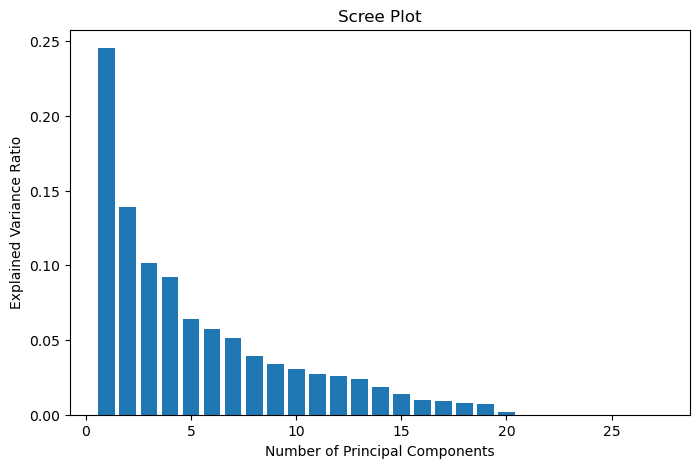

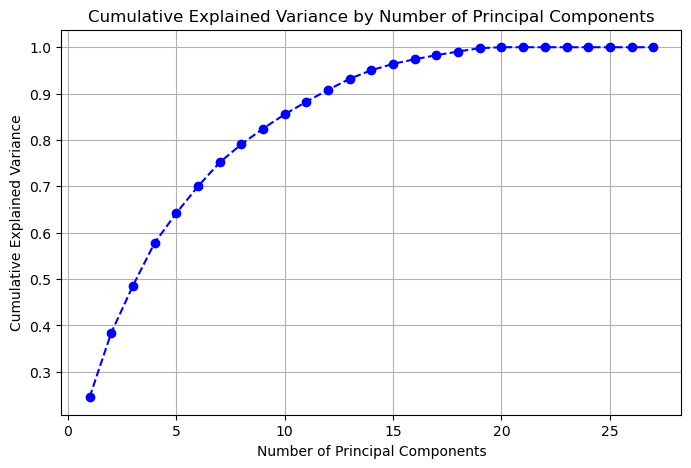

Explained Variance Ratios (3 PCs): ['0.245', '0.139', '0.102']
Cumulative (3 PCs): 0.486
Cumulative (12 PCs): 0.908


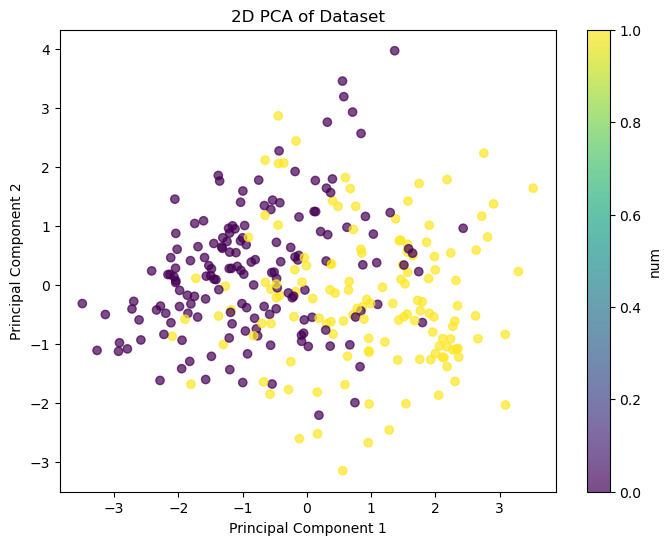

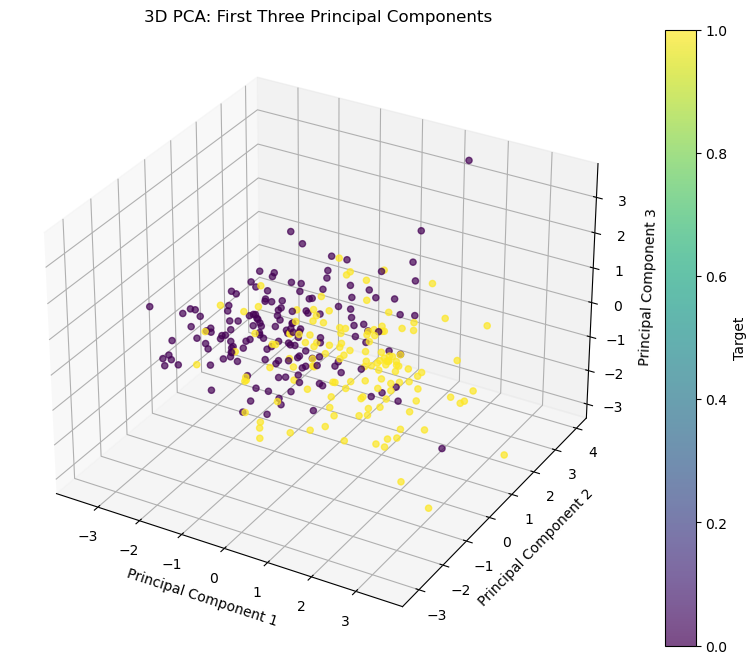

In [14]:
# Apply PCA
n_features = X_preproc.shape[1]

pca = PCA(n_components=n_features-1)
X_pca = pca.fit_transform(X_preproc, y)

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_features), pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Explained variance ratios
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_features), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print(f'Explained Variance Ratios (3 PCs): {[f"{val:.3f}" for val in pca.explained_variance_ratio_[:3]]}\n\
Cumulative (3 PCs): {np.sum(pca.explained_variance_ratio_[:3]):.3f}\n\
Cumulative (12 PCs): {np.sum(pca.explained_variance_ratio_[:12]):.3f}')

# Plot the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('2D PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='num')
plt.show()

# Plot the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)
ax.set_title('3D PCA: First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='Target')
plt.show()


Despite capturing the most significant variance (24.5%, 13.9% and 10.2%, respectively), the first, second and third principal components do not represent even 50% of the total.

However, considering that the normalized dataset has 28 features, it's a lot more interesting to work with the first 12 PCs, which have a cumulative explained variance ratio of 90.8%.

Given that the first few components do not visually cluster the data, it doesn't make much sense to test the generalization capability of this method.

<hr>

### UMAP

<hr>

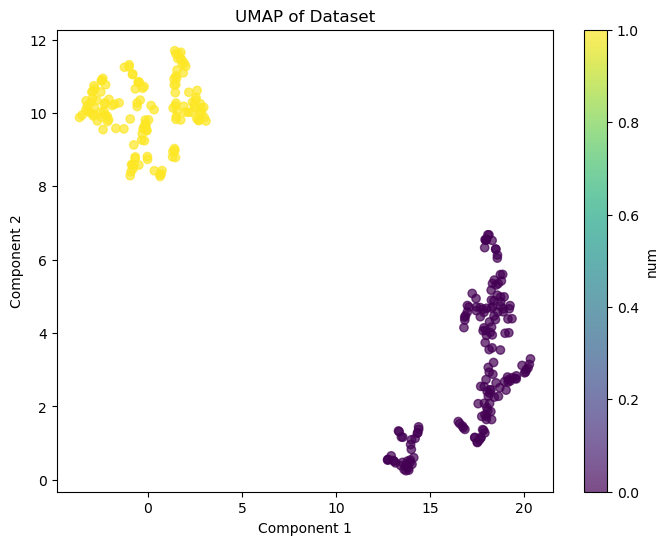

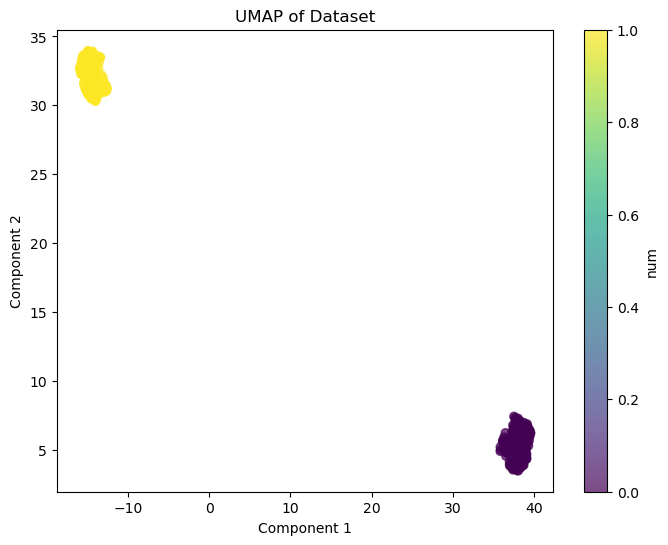

In [15]:
# Apply UMAP to raw and processed data
manifold_raw = umap.UMAP().fit(X, y)
X_raw_umap = manifold_raw.transform(X)
manifold = umap.UMAP().fit(X_preproc, y)
X_umap = manifold.transform(X_preproc)

# Plot the two resulting components (raw data)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_raw_umap[:, 0], X_raw_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('UMAP of Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='num')
plt.show()

# Plot the two resulting components (processed data)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('UMAP of Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='num')
plt.show()

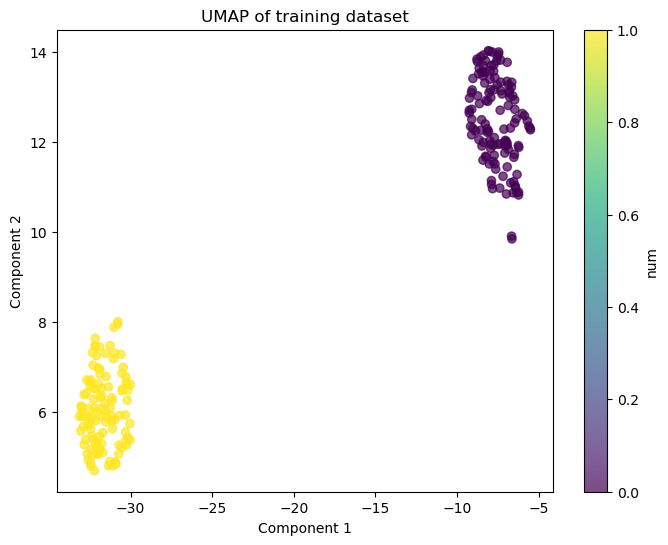

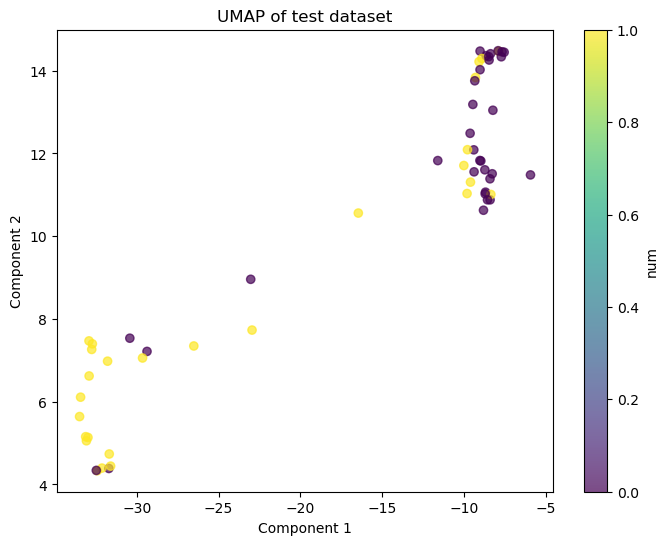

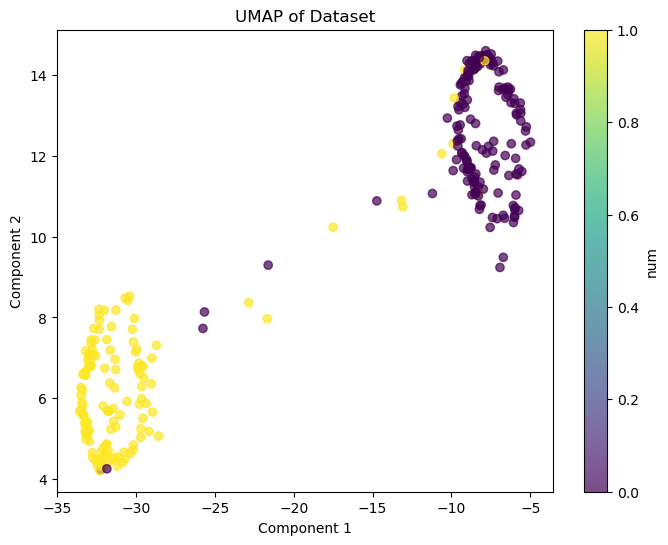

In [16]:
# --------------- Testing the generalization capability of UMAP -------------- #

# Split train and test data
train_X, test_X, train_y, test_y = train_test_split(X_preproc, y, test_size=.2, random_state=82024)

# Fit UMAP only to training data
manifold = umap.UMAP().fit(train_X, train_y)
X_train_umap = manifold.transform(train_X)

# Transform test data
X_test_umap = manifold.transform(test_X)
X_total_umap = manifold.transform(X_preproc)

# Plot training data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=train_y, cmap='viridis', alpha=0.7)
plt.title('UMAP of training dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='num')
plt.show()

# Plot test data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=test_y, cmap='viridis', alpha=0.7)
plt.title('UMAP of test dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='num')
plt.show()

# Plot all data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_total_umap[:, 0], X_total_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('UMAP of Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='num')
plt.show()

From the quick visual comparison above, it's easy to observe that the UMAP components are calcuated to really cluster the data, and don't work very well for unseen information. For this reason, PCA will be employed to reduce the dimentionality and pre-process the data.